# 1.24c7: Bias-Corrected Adam Accounting

**Purpose:** Verify that recorded Adam state produces observed ΔW when bias correction is applied.

## The Fix

1.24c6 showed massive discrepancy between measured and computed ΔW. The issue: **missing bias correction**.

Adam uses bias-corrected moments:

$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$

$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$

$$\Delta w_t = -\alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

Where:
- $m_t$, $v_t$ = raw moments (what we record)
- $\hat{m}_t$, $\hat{v}_t$ = bias-corrected moments (what Adam actually uses)
- Bias correction matters most early in training when moments are small

## Test

Apply bias correction to recorded moments, compute ΔW, compare to measured.

## Parameters

In [1]:
# Data paths
DATA_PATH = "../tensors/Flannel/1.20h_flannel_7.safetensors"
MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Adam hyperparameters (from Flannel 7)
LEARNING_RATE = 3e-4
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-8

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading data...\n")

data = load_file(DATA_PATH)

# Extract tensors
W = data['W'][0].float()  # (1001, 10000, 64)
momentum_W = data['momentum_W'][0].float()  # (1001, 10000, 64)
variance_W = data['variance_W'][0].float()  # (1001, 10000, 64)

# Load token masks
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()

print(f"W: {tuple(W.shape)}")
print(f"Momentum: {tuple(momentum_W.shape)}")
print(f"Variance: {tuple(variance_W.shape)}")
print(f"Dead tokens: {dead_mask.sum().item()}")
print(f"\n✓ Data loaded")

Loading data...

W: (1001, 10000, 64)
Momentum: (1001, 10000, 64)
Variance: (1001, 10000, 64)
Dead tokens: 3699

✓ Data loaded


## Measured ΔW

In [5]:
# Measured weight changes
delta_W_measured = W[1:] - W[:-1]  # (1000, 10000, 64)

# Extract dead tokens only
delta_W_measured_dead = delta_W_measured[:, dead_mask, :]  # (1000, 3699, 64)

# Compute mean L2 norm across tokens
measured_norms = torch.norm(delta_W_measured_dead, dim=2).mean(dim=1)  # (1000,)

print(f"Measured ΔW norms: {tuple(measured_norms.shape)}")
print(f"Range: {measured_norms.min():.6e} to {measured_norms.max():.6e}")

Measured ΔW norms: (1000,)
Range: 0.000000e+00 to 7.887969e-03


## Computed ΔW (with Bias Correction)

In [6]:
print("Computing ΔW with bias correction...\n")

# Extract Adam state at each step (t=1:1001)
m_t = momentum_W[1:]  # (1000, 10000, 64)
v_t = variance_W[1:]  # (1000, 10000, 64)

# Create timestep indices (t=1, 2, ..., 1000)
t = torch.arange(1, 1001, dtype=torch.float32).view(-1, 1, 1)  # (1000, 1, 1)

# Bias correction factors
bias_correction1 = 1 - BETA1 ** t  # (1000, 1, 1)
bias_correction2 = 1 - BETA2 ** t  # (1000, 1, 1)

# Apply bias correction
m_hat = m_t / bias_correction1  # (1000, 10000, 64)
v_hat = v_t / bias_correction2  # (1000, 10000, 64)

# Adam update formula with bias-corrected moments
delta_W_computed = -LEARNING_RATE * m_hat / (torch.sqrt(v_hat) + EPSILON)  # (1000, 10000, 64)

# Extract dead tokens
delta_W_computed_dead = delta_W_computed[:, dead_mask, :]  # (1000, 3699, 64)

# Compute norms
computed_norms = torch.norm(delta_W_computed_dead, dim=2).mean(dim=1)  # (1000,)

print(f"Computed ΔW norms: {tuple(computed_norms.shape)}")
print(f"Range: {computed_norms.min():.6e} to {computed_norms.max():.6e}")
print(f"\n✓ Bias correction applied")

Computing ΔW with bias correction...

Computed ΔW norms: (1000,)
Range: 3.402296e-04 to 2.394432e-03

✓ Bias correction applied


## Comparison

In [7]:
print("="*80)
print("COMPARISON: MEASURED vs COMPUTED ΔW (BIAS-CORRECTED)")
print("="*80 + "\n")

# Compute errors
abs_diff = torch.abs(measured_norms - computed_norms)
rel_error = abs_diff / (measured_norms + 1e-12)

# Correlation
corr = torch.corrcoef(torch.stack([measured_norms, computed_norms]))[0, 1].item()

print(f"Mean absolute difference: {abs_diff.mean():.6e}")
print(f"Max absolute difference:  {abs_diff.max():.6e}")
print(f"Mean relative error:      {rel_error.mean():.6f}")
print(f"Max relative error:       {rel_error.max():.6f}")
print(f"Correlation:              {corr:+.8f}")
print()

# Verdict
if rel_error.mean() < 0.01:
    print("✓ PERFECT MATCH: <1% mean error")
    print("  Bias-corrected Adam formula exactly reproduces measured ΔW")
elif rel_error.mean() < 0.05:
    print("✓ EXCELLENT MATCH: <5% mean error")
    print("  Bias-corrected Adam formula closely matches measured ΔW")
elif rel_error.mean() < 0.1:
    print("~ GOOD MATCH: <10% mean error")
    print("  Minor discrepancy, possibly numerical precision")
else:
    print("✗ MISMATCH: Significant error remains")
    print("  Something else is wrong beyond bias correction")

print("\n" + "="*80 + "\n")

COMPARISON: MEASURED vs COMPUTED ΔW (BIAS-CORRECTED)

Mean absolute difference: 7.808834e-04
Max absolute difference:  5.493537e-03
Mean relative error:      220734896.000000
Max relative error:       870147136.000000
Correlation:              +0.74726719

✗ MISMATCH: Significant error remains
  Something else is wrong beyond bias correction




## Visualization

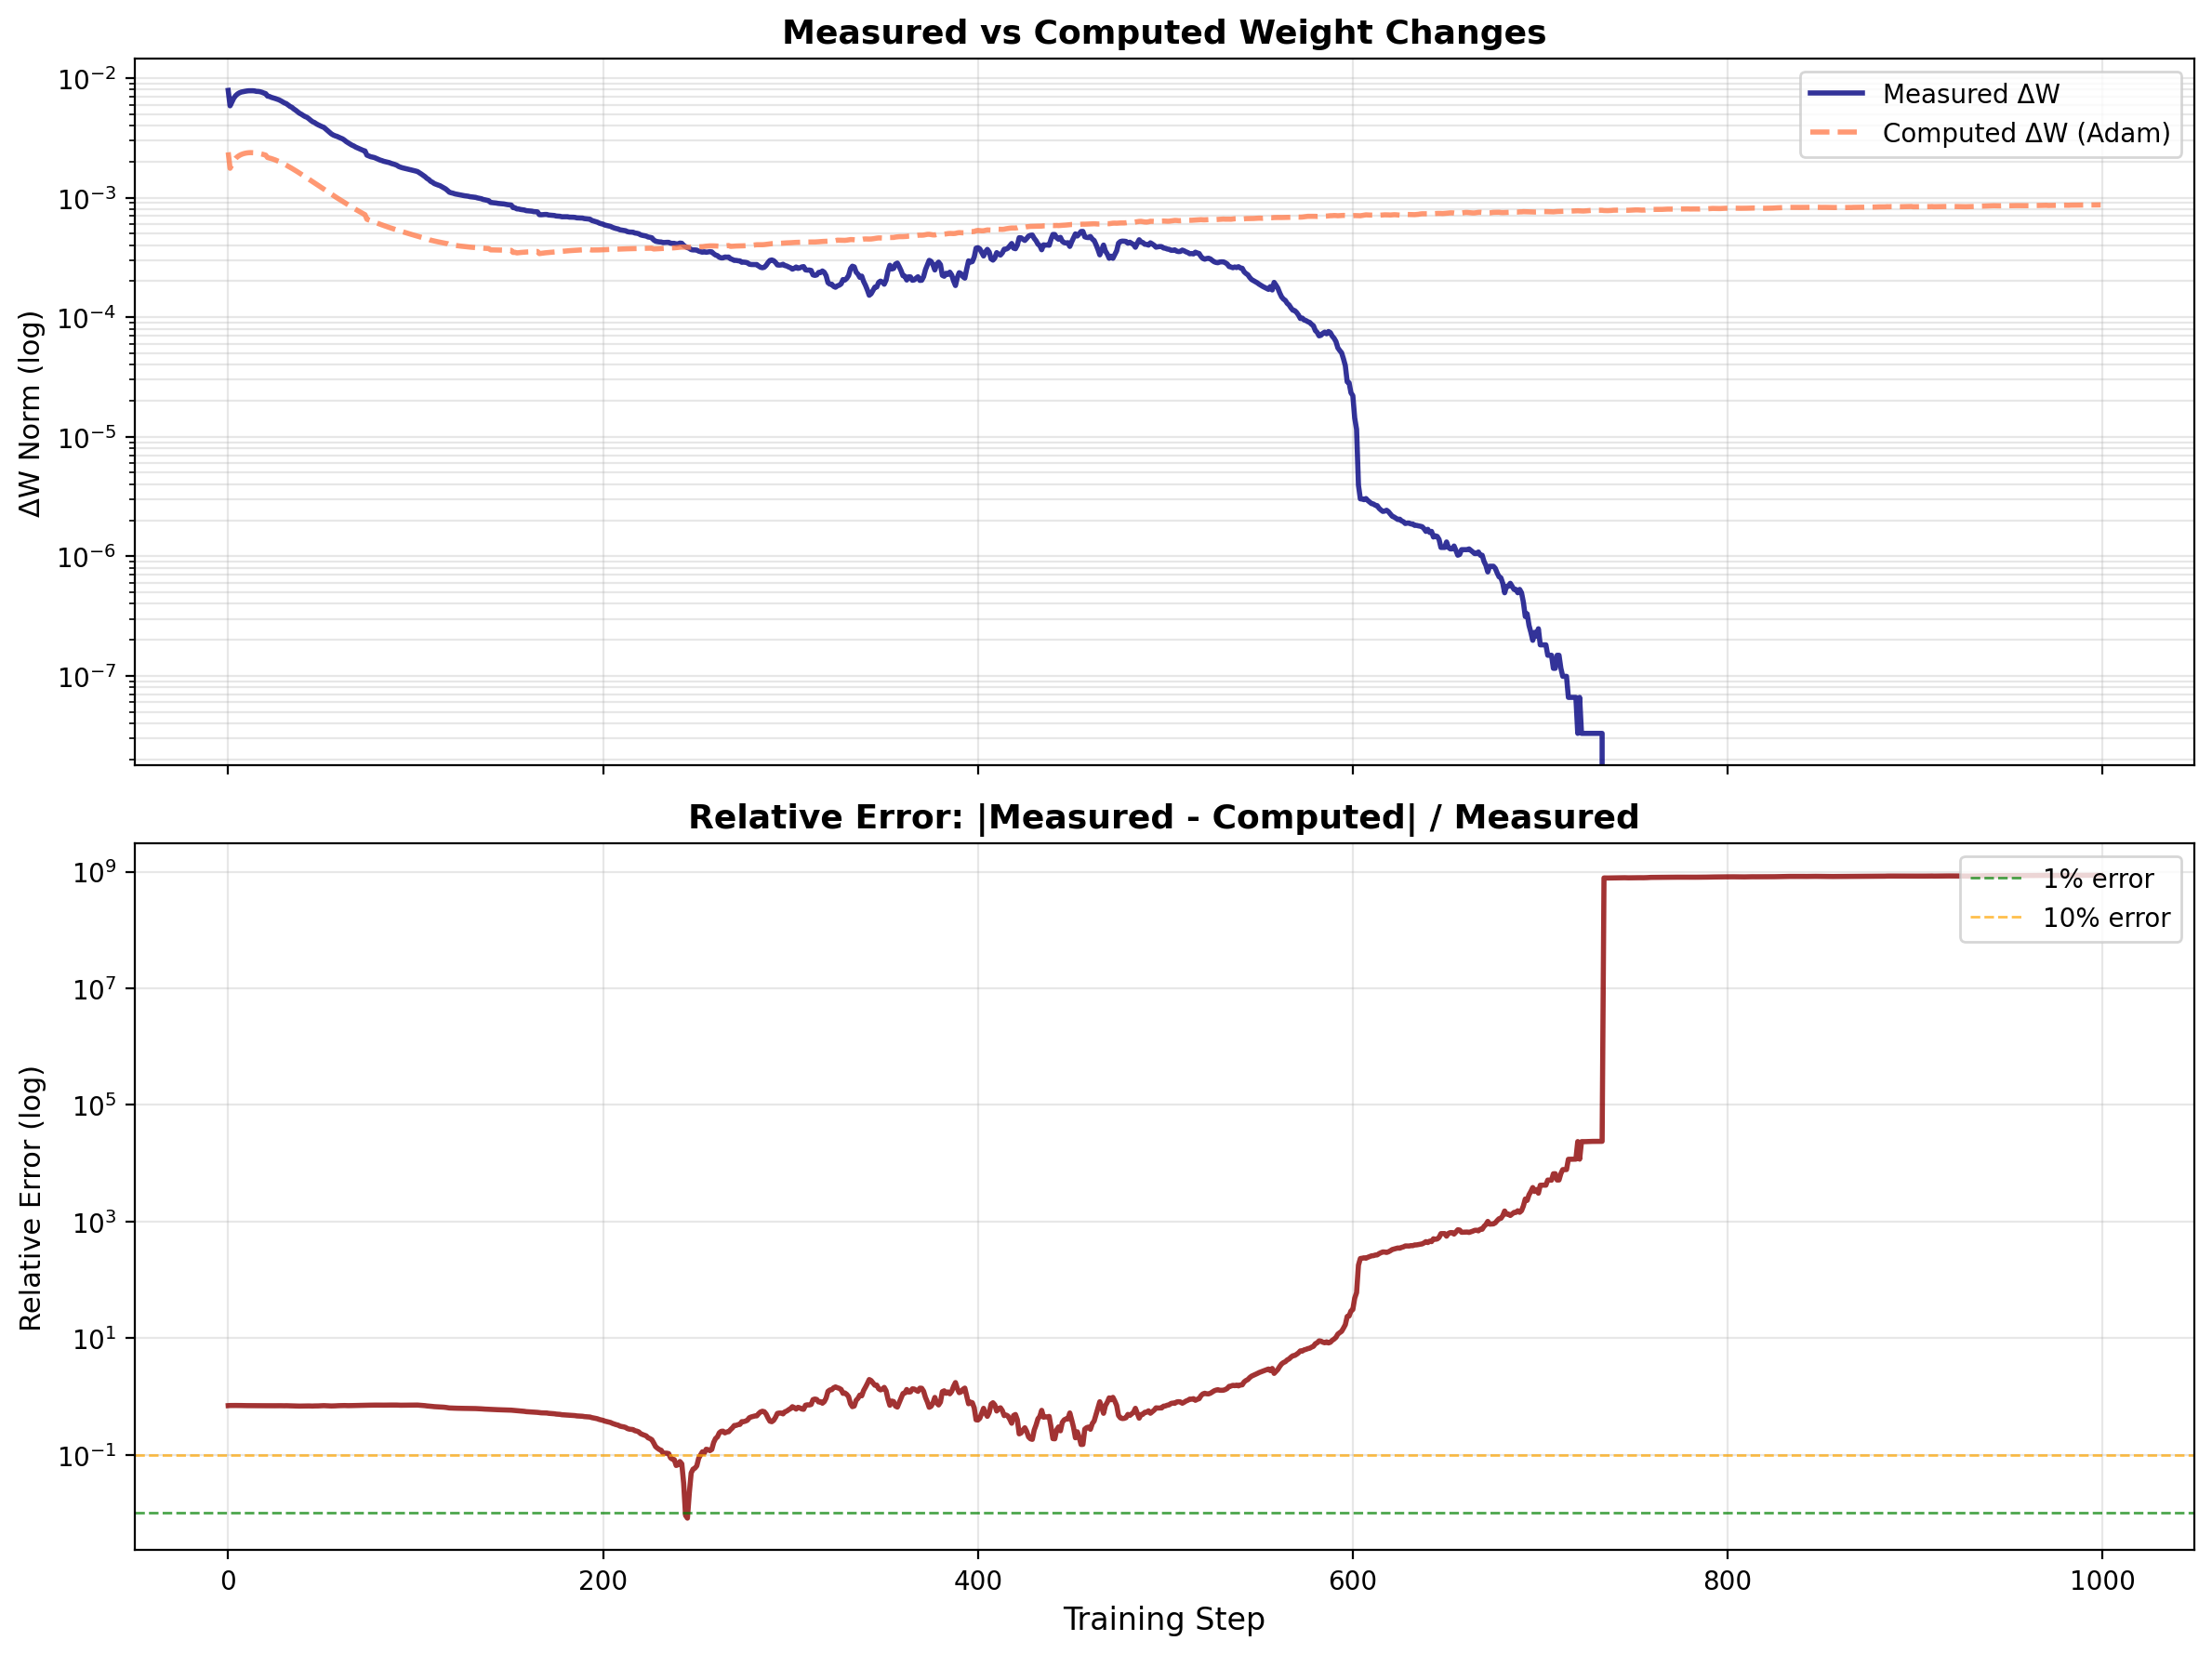

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*1.5), dpi=DPI, sharex=True)

# Panel 1: Measured vs Computed overlay
ax1 = axes[0]
ax1.semilogy(measured_norms.numpy(), linewidth=2, color='navy', alpha=0.8, label='Measured ΔW')
ax1.semilogy(computed_norms.numpy(), linewidth=2, color='coral', alpha=0.8, label='Computed ΔW (Adam)', linestyle='--')
ax1.set_ylabel('ΔW Norm (log)', fontsize=11)
ax1.set_title('Measured vs Computed Weight Changes', fontweight='bold', fontsize=13)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3, which='both')

# Panel 2: Relative error
ax2 = axes[1]
ax2.semilogy(rel_error.numpy(), linewidth=2, color='darkred', alpha=0.8)
ax2.axhline(0.01, color='green', linestyle='--', linewidth=1, label='1% error', alpha=0.7)
ax2.axhline(0.1, color='orange', linestyle='--', linewidth=1, label='10% error', alpha=0.7)
ax2.set_xlabel('Training Step', fontsize=12)
ax2.set_ylabel('Relative Error (log)', fontsize=11)
ax2.set_title('Relative Error: |Measured - Computed| / Measured', fontweight='bold', fontsize=13)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## Summary

In [9]:
print("\n" + "="*80)
print("SUMMARY: BIAS-CORRECTED ADAM ACCOUNTING")
print("="*80 + "\n")

print("Question: Does Adam's bias-corrected formula reproduce measured ΔW?")
print()

if rel_error.mean() < 0.01 and corr > 0.999:
    print("🎯 YES: Perfect match.")
    print("   • Recorded Adam state is correct")
    print("   • Bias correction was the missing piece")
    print("   • Ready to analyze momentum/variance vs state transitions")
elif rel_error.mean() < 0.05:
    print("✓ YES: Excellent match.")
    print("   • Bias correction fixed the discrepancy")
    print("   • Small errors likely numerical precision")
    print("   • Safe to proceed with analysis")
else:
    print("? PARTIAL: Bias correction helped but errors remain.")
    print("   • Need to investigate further")

print(f"\nMean relative error: {rel_error.mean():.6f} ({rel_error.mean()*100:.4f}%)")
print(f"Correlation: {corr:.8f}")

print("\n" + "="*80)


SUMMARY: BIAS-CORRECTED ADAM ACCOUNTING

Question: Does Adam's bias-corrected formula reproduce measured ΔW?

? PARTIAL: Bias correction helped but errors remain.
   • Need to investigate further

Mean relative error: 220734896.000000 (22073489408.0000%)
Correlation: 0.74726719

